In [1]:
from typing import Set
# Python imports, put at the top for simplicity
from logaut import ltl2dfa
from pylogics.parsers import parse_ltl
import pylogics.parsers.ldl
import logaut

from mdp_dp_rl.algorithms.dp.dp_analytic import DPAnalytic
from stochastic_service_composition.declare_utils import *
from stochastic_service_composition.dfa_target import from_symbolic_automaton_to_declare_automaton
from stochastic_service_composition.dfa_target import mdp_from_dfa
from docs.notebooks.utils import render_service, render_target, render_composition_mdp, render_mdp_dfa, \
    print_policy_data, print_value_function, print_q_value_function, render_comp_mdp
from stochastic_service_composition.composition_mdp import composition_mdp, comp_mdp
from stochastic_service_composition.services import build_service_from_transitions, Service
from stochastic_service_composition.target import build_target_from_transitions, target_from_dfa


## Use case for "Stochastic Service Composition with Industrial APIs" - Chip Production.

In this notebook, we present the implementation of the use case for "Stochastic Service Composition with Industrial APIs" about chip production.

# Available Services

In the following we provide definitions about available services:

In [2]:
LOW_PROB = 0.05

# probabilities of being broken after an action
DEFAULT_BROKEN_PROB = LOW_PROB
BROKEN_PROB = 0.5
HIGH_BROKEN_PROB = 0.7

# default probability of being unemployable after the configuration
DEFAULT_UNEMPLOYABLE_PROB = LOW_PROB
HIGH_UNEMPLOYABLE_PROB = 0.5

# costs of the machines that perform their job in different countries
DEFAULT_USA_REWARD = -1.0
WAR_REWARD = -3.0
USA_REWARD = -2.0
HIGH_USA_REWARD = -5.0
UK_REWARD = -6.8
CHINA_REWARD = -11.7
TAIWAN_REWARD = -12.2
RUSSIA_REWARD = -9.12 # we have to take into the account political problems
NORWAY_REWARD = -7.16
AUSTRALIA_REWARD = -14.0
INDIA_REWARD = -13.1
BELGIUM_REWARD = -7.6
SWITZERLAND_REWARD = -8.0
CANADA_REWARD = -1.8
PERU_REWARD = -6.0
AUSTRIA_REWARD = -8.38
BRAZIL_REWARD = -6.7
FRANCE_REWARD = -7.6
MALAYSIA_REWARD = -14.73
TURKEY_REWARD = -10.16
KAZAKHSTAN_REWARD = -10.4
CHILE_REWARD = -7.8
BOLIVIA_REWARD = -6.8
ARGENTINA_REWARD = -8.55
MOROCCO_REWARD = -7.9
JAPAN_REWARD = -10.1
SOUTH_KOREA = -10.7
NETHERLANDS_REWARD = -7.5

# default reward when the service becomes broken
DEFAULT_BROKEN_REWARD = -10.0

In [3]:
# all the atomic actions for the task
PICK_BUY_DESIGN = "pick_buy_design"
PICK_SILICON = "pick_silicon"
PICK_WAFER = "pick_wafer"
PICK_BORON = "pick_boron"
PICK_PHOSPHOR = "pick_phosphor"
PICK_ALUMINUM = "pick_aluminum"
PICK_RESIST = "pick_resist"
PICK_PLASTIC = "pick_plastic"
PICK_CHEMICALS = "pick_chemicals"
PICK_COPPER_FRAME = "pick_copper_frame"
CLEANING = "cleaning"
CONFIG_FILM_DEPOSITION = "config_film_deposition"
CHECKED_FILM_DEPOSITION = "checked_film_deposition"
FILM_DEPOSITION = "film_deposition"
CONFIG_RESIST_COATING = "config_resist_coating"
CHECKED_RESIST_COATING = "checked_resist_coating"
RESIST_COATING = "resist_coating"
EXPOSURE = "exposure"
CHECK_EXPOSURE = "check_exposure"
CONFIG_DEVELOPMENT = "config_development"
CHECKED_DEVELOPMENT = "checked_development"
DEVELOPMENT = "development"
ETCHING = "etching"
CHECK_ETCHING = "check_etching"
CONFIG_IMPURITIES_IMPLANTATION = "config_impurities_implantation"
CHECKED_IMPURITIES_IMPLANTATION = "checked_impurities_implantation"
IMPURITIES_IMPLANTATION = "impurities_implantation"
ACTIVATION = "activation"
RESIST_STRIPPING = "resist_stripping"
CHECK_RESIST_STRIPPING = "check_resist_stripping"
ASSEMBLY = "assembly"
TESTING ="testing"
PACKAGING = "packaging"

SYMBOLS_PHASE_1 = [
    PICK_BUY_DESIGN,
    PICK_SILICON,
    PICK_WAFER,
    PICK_BORON,
    PICK_PHOSPHOR,
    PICK_ALUMINUM,
    PICK_RESIST,
    PICK_PLASTIC,
    PICK_CHEMICALS,
    PICK_COPPER_FRAME
]

SYMBOLS_PHASE_2 = [
    CLEANING,
    CONFIG_FILM_DEPOSITION,
    CHECKED_FILM_DEPOSITION,
    FILM_DEPOSITION,
    CONFIG_RESIST_COATING,
    CHECKED_RESIST_COATING,
    RESIST_COATING,
    EXPOSURE,
    CHECK_EXPOSURE,
    CONFIG_DEVELOPMENT,
    CHECKED_DEVELOPMENT,
    DEVELOPMENT,
    ETCHING,
    CHECK_ETCHING,
    CONFIG_IMPURITIES_IMPLANTATION,
    CHECKED_IMPURITIES_IMPLANTATION,
    IMPURITIES_IMPLANTATION,
    ACTIVATION,
    RESIST_STRIPPING,
    CHECK_RESIST_STRIPPING,
    ASSEMBLY,
    TESTING,
    PACKAGING
]

In [4]:
# service names
DESIGN_SERVICE_NAME_USA = "design_usa"                                      # human
DESIGN_SERVICE_NAME_UK = "design_uk"                                        # human
DESIGN_SERVICE_NAME_CHINA = "design_china"                                  # human
DESIGN_SERVICE_NAME_TAIWAN = "design_taiwan"                                # human
SILICON_SERVICE_NAME_CHINA = "silicon_china"                                # warehouse
SILICON_SERVICE_NAME_RUSSIA = "silicon_russia"                              # warehouse
SILICON_SERVICE_NAME_NORWAY = "silicon_norway"                              # warehouse
SILICON_SERVICE_NAME_USA = "silicon_usa"                                    # warehouse
SILICON_SERVICE_NAME_FRANCE = "silicon_france"                              # warehouse
SILICON_SERVICE_NAME_BRAZIL = "silicon_brazil"                              # warehouse
SILICON_SERVICE_NAME_MALAYSIA = "silicon_malaysia"                          # warehouse
WAFER_SERVICE_NAME_JAPAN = "wafer_japan"                                    # warehouse
WAFER_SERVICE_NAME_SOUTH_KOREA = "wafer_south_korea"                        # warehouse
BORON_SERVICE_NAME_TURKEY = "boron_turkey"                                  # warehouse
BORON_SERVICE_NAME_USA = "boron_usa"                                        # warehouse
BORON_SERVICE_NAME_KAZAKHSTAN = "boron_kazakhstan"                          # warehouse
BORON_SERVICE_NAME_CHILE = "boron_chile"                                    # warehouse
BORON_SERVICE_NAME_CHINA = "boron_china"                                    # warehouse
BORON_SERVICE_NAME_ARGENTINA = "boron_argentina"                            # warehouse
BORON_SERVICE_NAME_RUSSIA = "boron_russia"                                  # warehouse
BORON_SERVICE_NAME_BOLIVIA = "boron_bolivia"                                # warehouse
PHOSPHOR_SERVICE_NAME_MOROCCO = "phosphor_morocco"                          # warehouse
PHOSPHOR_SERVICE_NAME_CHINA = "phosphor_china"                              # warehouse
PHOSPHOR_SERVICE_NAME_USA = "phosphor_usa"                                  # warehouse
ALUMINUM_SERVICE_NAME_AUSTRALIA = "aluminum_australia"                      # warehouse
ALUMINUM_SERVICE_NAME_INDIA = "aluminum_india"                              # warehouse
ALUMINUM_SERVICE_NAME_BRAZIL = "aluminum_brazil"                            # warehouse
RESIST_SERVICE_NAME_USA = "resist_usa"                                      # warehouse
RESIST_SERVICE_NAME_BELGIUM = "resist_belgium"                              # warehouse
RESIST_SERVICE_NAME_AUSTRIA = "resist_austria"                              # warehouse
RESIST_SERVICE_NAME_INDIA = "resist_india"                                  # warehouse
RESIST_SERVICE_NAME_SWITZERLAND = "resist_switzerland"                      # warehouse
RESIST_SERVICE_NAME_CANADA = "resist_canada"                                # warehouse
PLASTIC_SERVICE_NAME_CHINA = "plastic_china"                                # warehouse
PLASTIC_SERVICE_NAME_INDIA = "plastic_india"                                # warehouse
CHEMICALS_SERVICE_NAME_USA = "chemicals_usa"                                # warehouse
CHEMICALS_SERVICE_NAME_CANADA = "chemicals_canada"                          # warehouse
COPPER_FRAME_SERVICE_NAME_USA = "copper_frame_usa"                          # warehouse
COPPER_FRAME_SERVICE_NAME_CHINA = "copper_frame_china"                      # warehouse
COPPER_FRAME_SERVICE_NAME_PERU = "copper_frame_peru"                        # warehouse
COPPER_FRAME_SERVICE_NAME_CHILE = "copper_frame_chile"                      # warehouse
CLEANING_SERVICE_NAME = "cleaning_human"                                    # human
FILM_DEPOSITION1_SERVICE_NAME = "film_deposition_machine1"                  # machine
FILM_DEPOSITION2_SERVICE_NAME = "film_deposition_machine2"                  # machine
RESIST_COATING1_SERVICE_NAME = "resist_coating_machine1"                    # machine
RESIST_COATING2_SERVICE_NAME = "resist_coating_machine2"                    # machine
EXPOSURE_SERVICE_NAME = "exposure_machine"                                  # machine
DEVELOPMENT1_SERVICE_NAME = "development1_machine"                          # machine
DEVELOPMENT2_SERVICE_NAME = "development2_machine"                          # machine
ETCHING1_SERVICE_NAME = "etching1_machine"                                  # machine
ETCHING2_SERVICE_NAME = "etching2_machine"                                  # machine
IMPURITIES_IMPLANTATION_SERVICE_NAME = "impurities_implantation_machine"    # machine
ACTIVATION_SERVICE_NAME = "activation_human"                                # human
RESIST_STRIPPING_SERVICE_NAME = "resist_stripping_machine"                  # machine
ASSEMBLY_SERVICE_NAME = "assembly_human"                                    # human
TESTING_SERVICE_NAME = "testing_human"                                      # human
PACKAGING_SERVICE_NAME = "packaging_human"                                  # human

We have different type of services:

- generic breakable machines;
- complex breakable machines;
- warehouse machines;
- human workers

In [5]:
def build_generic_breakable_service(service_name: str, action_name: str, broken_prob: float, broken_reward: float, action_reward: float):
    assert 0.0 <= broken_prob <= 1.0
    deterministic_prob = 1.0
    success_prob = deterministic_prob - broken_prob
    transitions = {
        "available": {
          action_name: ({"done": success_prob, "broken": broken_prob}, action_reward),
        },
        "broken": {
            f"check_{action_name}": ({"available": 1.0}, broken_reward),
        },
        "done": {
            f"check_{action_name}": ({"available": 1.0}, 0.0),
        }
    }
    final_states = {"available"}
    initial_state = "available"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

def build_complex_breakable_service(service_name: str, action_name: str, broken_prob: float, unemployable_prob: float, broken_reward: float, action_reward: float) -> Service:
    assert 0.0 <= broken_prob <= 1.0
    deterministic_prob = 1.0
    configure_success_prob = deterministic_prob - unemployable_prob
    op_success_prob = deterministic_prob - broken_prob
    transitions = {
        "ready": { # current state
            f"config_{action_name}": # action
                (
                    {
                        "configured": deterministic_prob # next state : prob
                    },
                    0.0
                ),
        },
        "configured": {
            f"checked_{action_name}":
                (
                    {
                    "executing": configure_success_prob,
                    "broken": unemployable_prob
                    } if unemployable_prob > 0.0 else {"executing": configure_success_prob},
                    0.0
                ),
        },
        "executing": {
            action_name: # operation
                (
                    {
                        "ready": op_success_prob,
                        "broken": broken_prob
                    } if broken_prob > 0.0 else {"ready": op_success_prob},
                    action_reward
                ),
        },
        "broken": {
            f"restore_{action_name}":
               (
                   {
                       "repairing": deterministic_prob
                   },
                   broken_reward
               ),
        },
        "repairing": {
            f"repaired_{action_name}":
                (
                    {
                        "ready": deterministic_prob
                    },
                    0.0
                ),
        },

    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

def build_generic_service_one_state(
    service_name: str,
    operation_names: Set[str],
    action_reward: float,
) -> Service:
    """Build the one state device."""
    transitions = {
        "ready": {
            operation_name: ({"ready": 1.0}, action_reward) for operation_name in operation_names
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

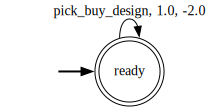

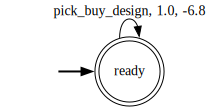

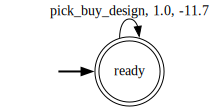

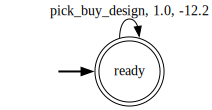

In [6]:
def design_service(name: str, action_reward: float) -> Service:
    """Build the design device."""
    return build_generic_service_one_state(
        name,
        {PICK_BUY_DESIGN},
        action_reward=action_reward
    )

service_design_usa = design_service(DESIGN_SERVICE_NAME_USA, USA_REWARD)
service_design_uk = design_service(DESIGN_SERVICE_NAME_UK, UK_REWARD)
service_design_china = design_service(DESIGN_SERVICE_NAME_CHINA, CHINA_REWARD)
service_design_taiwan = design_service(DESIGN_SERVICE_NAME_TAIWAN, TAIWAN_REWARD)
render_service(service_design_usa)
render_service(service_design_uk)
render_service(service_design_china)
render_service(service_design_taiwan)

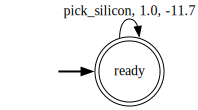

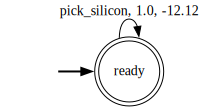

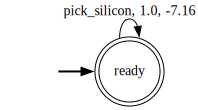

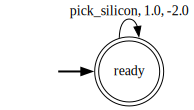

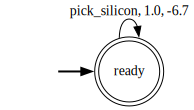

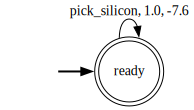

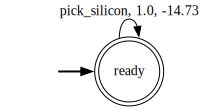

In [7]:
def silicon_warehouse_service(name: str, action_reward) -> Service:
    """Build the silicon warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_SILICON},
        action_reward=action_reward
    )

service_silicon_china = silicon_warehouse_service(SILICON_SERVICE_NAME_CHINA, CHINA_REWARD)
service_silicon_russia = silicon_warehouse_service(SILICON_SERVICE_NAME_RUSSIA, RUSSIA_REWARD + WAR_REWARD)
service_silicon_norway = silicon_warehouse_service(SILICON_SERVICE_NAME_NORWAY, NORWAY_REWARD)
service_silicon_usa = silicon_warehouse_service(SILICON_SERVICE_NAME_USA, USA_REWARD)
service_silicon_brazil = silicon_warehouse_service(SILICON_SERVICE_NAME_BRAZIL, BRAZIL_REWARD)
service_silicon_france = silicon_warehouse_service(SILICON_SERVICE_NAME_FRANCE, FRANCE_REWARD)
service_silicon_malaysia = silicon_warehouse_service(SILICON_SERVICE_NAME_MALAYSIA, MALAYSIA_REWARD)
render_service(service_silicon_china)
render_service(service_silicon_russia)
render_service(service_silicon_norway)
render_service(service_silicon_usa)
render_service(service_silicon_brazil)
render_service(service_silicon_france)
render_service(service_silicon_malaysia)

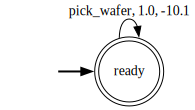

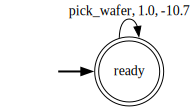

In [8]:
def wafer_warehouse_service(name: str, action_reward: float) -> Service:
    """Build the wafer warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_WAFER},
        action_reward=action_reward
    )

service_wafer_japan = wafer_warehouse_service(WAFER_SERVICE_NAME_JAPAN, JAPAN_REWARD)
service_wafer_south_korea = wafer_warehouse_service(WAFER_SERVICE_NAME_SOUTH_KOREA, SOUTH_KOREA)
render_service(service_wafer_japan)
render_service(service_wafer_south_korea)

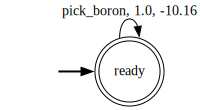

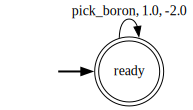

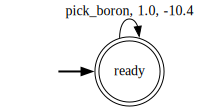

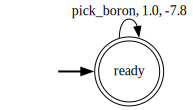

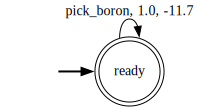

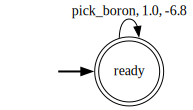

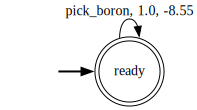

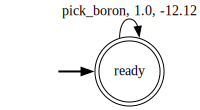

In [9]:
def boron_warehouse_service(name: str, action_reward: float) -> Service:
    """Build the boron warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_BORON},
        action_reward=action_reward
    )

service_boron_turkey = boron_warehouse_service(BORON_SERVICE_NAME_TURKEY, TURKEY_REWARD)
service_boron_usa = boron_warehouse_service(BORON_SERVICE_NAME_USA, USA_REWARD)
service_boron_kazakhstan = boron_warehouse_service(BORON_SERVICE_NAME_KAZAKHSTAN, KAZAKHSTAN_REWARD)
service_boron_chile = boron_warehouse_service(BORON_SERVICE_NAME_CHILE, CHILE_REWARD)
service_boron_china = boron_warehouse_service(BORON_SERVICE_NAME_CHINA, CHINA_REWARD)
service_boron_bolivia = boron_warehouse_service(BORON_SERVICE_NAME_BOLIVIA, BOLIVIA_REWARD)
service_boron_argentina = boron_warehouse_service(BORON_SERVICE_NAME_ARGENTINA, ARGENTINA_REWARD)
service_boron_russia = boron_warehouse_service(BORON_SERVICE_NAME_RUSSIA, RUSSIA_REWARD + WAR_REWARD)
render_service(service_boron_turkey)
render_service(service_boron_usa)
render_service(service_boron_kazakhstan)
render_service(service_boron_chile)
render_service(service_boron_china)
render_service(service_boron_bolivia)
render_service(service_boron_argentina)
render_service(service_boron_russia)

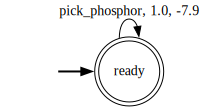

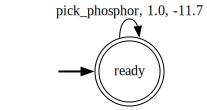

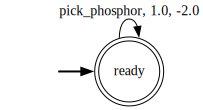

In [10]:
def phosphor_warehouse_service(name: str, action_reward: float) -> Service:
    """Build the phosphor warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_PHOSPHOR},
        action_reward=action_reward
    )

service_phosphor_morocco = phosphor_warehouse_service(PHOSPHOR_SERVICE_NAME_MOROCCO, MOROCCO_REWARD)
service_phosphor_china = phosphor_warehouse_service(PHOSPHOR_SERVICE_NAME_CHINA, CHINA_REWARD)
service_phosphor_usa = phosphor_warehouse_service(PHOSPHOR_SERVICE_NAME_USA, USA_REWARD)
render_service(service_phosphor_morocco)
render_service(service_phosphor_china)
render_service(service_phosphor_usa)

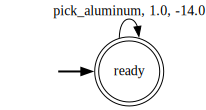

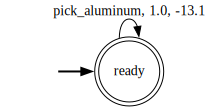

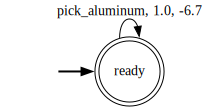

In [11]:
def aluminum_warehouse_service(name: str, action_reward: float) -> Service:
    """Build the aluminum warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_ALUMINUM},
        action_reward=action_reward
    )

service_aluminum_australia = aluminum_warehouse_service(ALUMINUM_SERVICE_NAME_AUSTRALIA, AUSTRALIA_REWARD)
service_aluminum_india = aluminum_warehouse_service(ALUMINUM_SERVICE_NAME_INDIA, INDIA_REWARD)
service_aluminum_brazil = aluminum_warehouse_service(ALUMINUM_SERVICE_NAME_BRAZIL, BRAZIL_REWARD)
render_service(service_aluminum_australia)
render_service(service_aluminum_india)
render_service(service_aluminum_brazil)

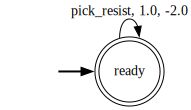

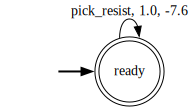

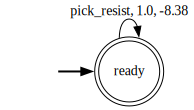

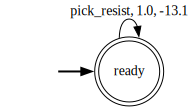

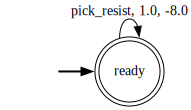

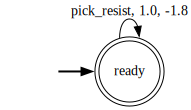

In [12]:
def resist_warehouse_service(name: str, action_reward: float) -> Service:
    """Build the resist warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_RESIST},
        action_reward=action_reward
    )


service_resist_usa = resist_warehouse_service(RESIST_SERVICE_NAME_USA, USA_REWARD)
service_resist_belgium = resist_warehouse_service(RESIST_SERVICE_NAME_BELGIUM, BELGIUM_REWARD)
service_resist_austria = resist_warehouse_service(RESIST_SERVICE_NAME_AUSTRIA, AUSTRIA_REWARD)
service_resist_india = resist_warehouse_service(RESIST_SERVICE_NAME_INDIA, INDIA_REWARD)
service_resist_switzerland = resist_warehouse_service(RESIST_SERVICE_NAME_SWITZERLAND, SWITZERLAND_REWARD)
service_resist_canada = resist_warehouse_service(RESIST_SERVICE_NAME_CANADA, CANADA_REWARD)
render_service(service_resist_usa)
render_service(service_resist_belgium)
render_service(service_resist_austria)
render_service(service_resist_india)
render_service(service_resist_switzerland)
render_service(service_resist_canada)

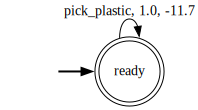

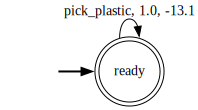

In [13]:
def plastic_warehouse_service(name: str, action_reward: float) -> Service:
    """Build the plastic warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_PLASTIC},
        action_reward=action_reward
    )


service_plastic_china = plastic_warehouse_service(PLASTIC_SERVICE_NAME_CHINA, CHINA_REWARD)
service_plastic_india = plastic_warehouse_service(PLASTIC_SERVICE_NAME_INDIA, INDIA_REWARD)
render_service(service_plastic_china)
render_service(service_plastic_india)

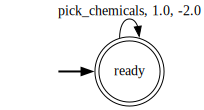

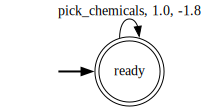

In [14]:
def chemicals_warehouse_service(name: str, action_reward: float) -> Service:
    """Build the chemicals warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_CHEMICALS},
        action_reward=action_reward
    )


service_chemicals_usa = chemicals_warehouse_service(CHEMICALS_SERVICE_NAME_USA, USA_REWARD)
service_chemicals_canada = chemicals_warehouse_service(CHEMICALS_SERVICE_NAME_CANADA, CANADA_REWARD)
render_service(service_chemicals_usa)
render_service(service_chemicals_canada)

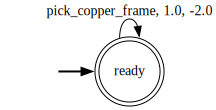

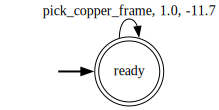

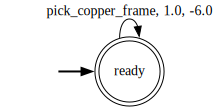

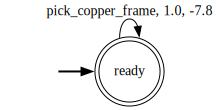

In [15]:
def copper_frame_warehouse_service(name: str, action_reward: float) -> Service:
    """Build the copper frame warehouse device."""
    return build_generic_service_one_state(
        name,
        {PICK_COPPER_FRAME},
        action_reward=action_reward
    )


service_copper_frame_usa = copper_frame_warehouse_service(COPPER_FRAME_SERVICE_NAME_USA, USA_REWARD)
service_copper_frame_china = copper_frame_warehouse_service(COPPER_FRAME_SERVICE_NAME_CHINA, CHINA_REWARD)
service_copper_frame_peru = copper_frame_warehouse_service(COPPER_FRAME_SERVICE_NAME_PERU, PERU_REWARD)
service_copper_frame_chile = copper_frame_warehouse_service(COPPER_FRAME_SERVICE_NAME_CHILE, CHILE_REWARD)
render_service(service_copper_frame_usa)
render_service(service_copper_frame_china)
render_service(service_copper_frame_peru)
render_service(service_copper_frame_chile)

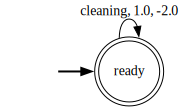

In [16]:
def cleaning_service(name: str = CLEANING_SERVICE_NAME, action_reward: float = USA_REWARD) -> Service:
    """Build the human cleaning device."""
    return build_generic_service_one_state(
        name,
        {CLEANING},
        action_reward=action_reward
    )


service_cleaning = cleaning_service()
render_service(service_cleaning)


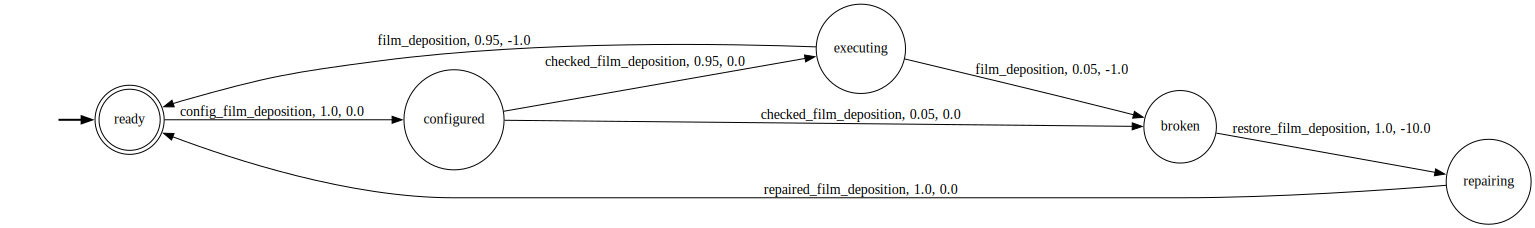

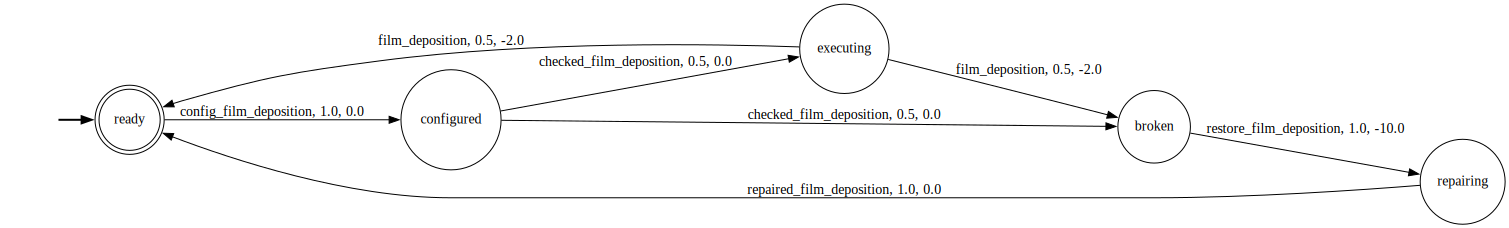

In [17]:
def film_deposition_service(name: str, broken_prob: float, unemployable_prob: float, broken_reward: float,
                            action_reward: float) -> Service:
    """Build the film deposition device."""
    return build_complex_breakable_service(name, FILM_DEPOSITION, broken_prob=broken_prob,
                                           unemployable_prob=unemployable_prob, broken_reward=broken_reward,
                                           action_reward=action_reward)


service_film_deposition1 = film_deposition_service(FILM_DEPOSITION1_SERVICE_NAME, DEFAULT_BROKEN_PROB,
                                                   DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD)
service_film_deposition2 = film_deposition_service(FILM_DEPOSITION2_SERVICE_NAME, BROKEN_PROB, HIGH_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, USA_REWARD)
render_service(service_film_deposition1)
render_service(service_film_deposition2)

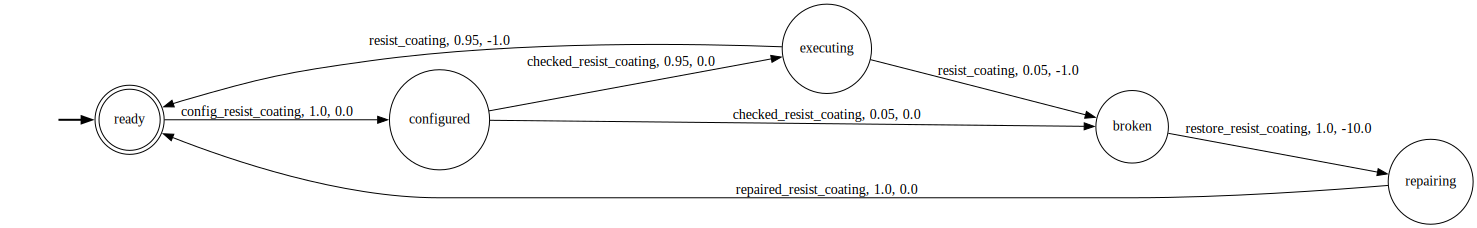

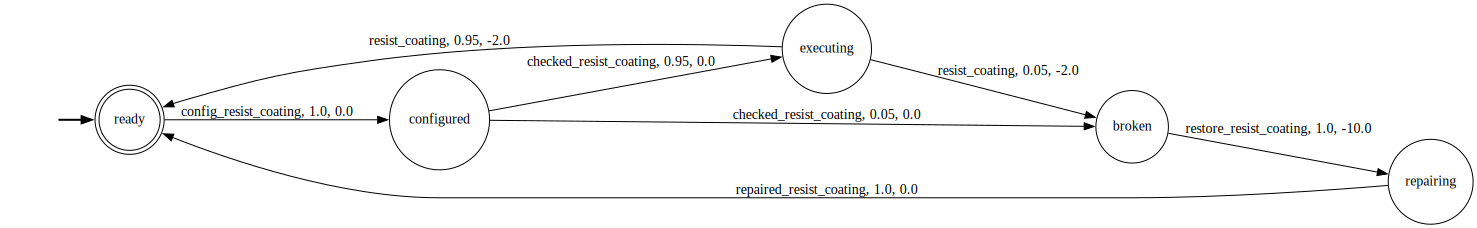

In [18]:
def resist_coating_service(name: str, broken_prob: float, unemployable_prob: float, broken_reward: float,
                           action_reward: float) -> Service:
    """Build the resist coating device."""
    return build_complex_breakable_service(name, RESIST_COATING, broken_prob=broken_prob,
                                           unemployable_prob=unemployable_prob, broken_reward=broken_reward,
                                           action_reward=action_reward)


service_resist_coating1 = resist_coating_service(RESIST_COATING1_SERVICE_NAME, DEFAULT_BROKEN_PROB,
                                                 DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD)
service_resist_coating2 = resist_coating_service(RESIST_COATING2_SERVICE_NAME, DEFAULT_BROKEN_PROB,
                                                 DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, USA_REWARD)
render_service(service_resist_coating1)
render_service(service_resist_coating2)

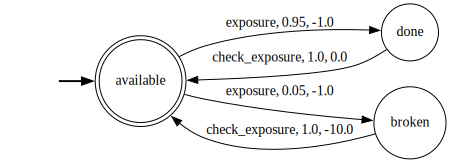

In [19]:
def exposure_service(name: str = EXPOSURE_SERVICE_NAME, broken_prob: float = DEFAULT_BROKEN_PROB,
                     broken_reward: float = DEFAULT_BROKEN_REWARD,
                     action_reward: float = DEFAULT_USA_REWARD) -> Service:
    """Build the exposure device."""
    return build_generic_breakable_service(name, EXPOSURE, broken_prob=broken_prob, broken_reward=broken_reward,
                                           action_reward=action_reward)


service_exposure = exposure_service()
render_service(service_exposure)

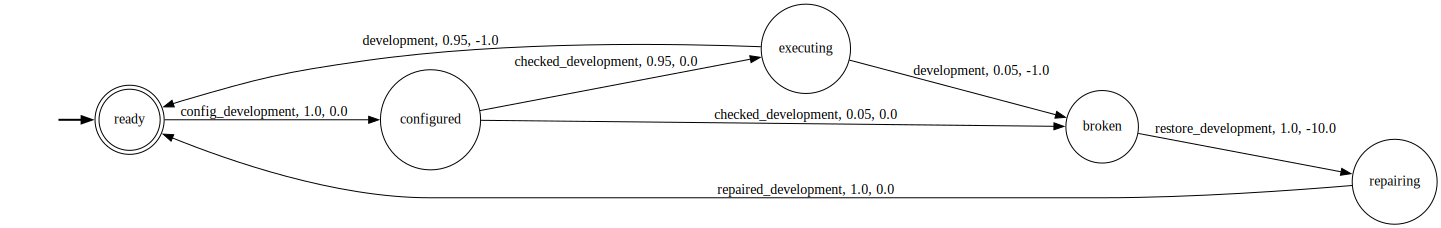

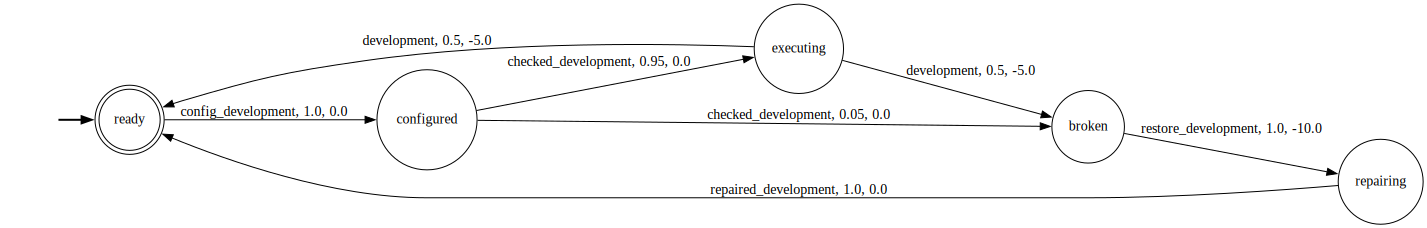

In [20]:
def development_service(name: str, broken_prob: float, unemployable_prob: float, broken_reward: float,
                        action_reward: float) -> Service:
    """Build the development device."""
    return build_complex_breakable_service(name, DEVELOPMENT, broken_prob=broken_prob,
                                           unemployable_prob=unemployable_prob, broken_reward=broken_reward,
                                           action_reward=action_reward)


service_development1 = development_service(DEVELOPMENT1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB,
                                           DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD)
service_development2 = development_service(DEVELOPMENT2_SERVICE_NAME, BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, HIGH_USA_REWARD)
render_service(service_development1)
render_service(service_development2)


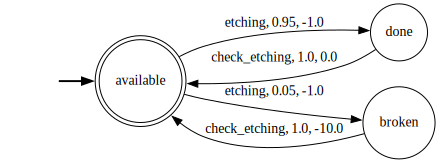

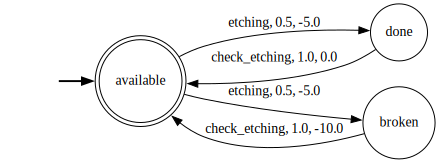

In [21]:
def etching_service(name: str, broken_prob: float, broken_reward: float, action_reward: float) -> Service:
    """Build the etching device."""
    return build_generic_breakable_service(name, ETCHING, broken_prob=broken_prob, broken_reward=broken_reward,
                                           action_reward=action_reward)


service_etching1 = etching_service(ETCHING1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD,
                                   DEFAULT_USA_REWARD)
service_etching2 = etching_service(ETCHING2_SERVICE_NAME, BROKEN_PROB, DEFAULT_BROKEN_REWARD, HIGH_USA_REWARD)
render_service(service_etching1)
render_service(service_etching2)


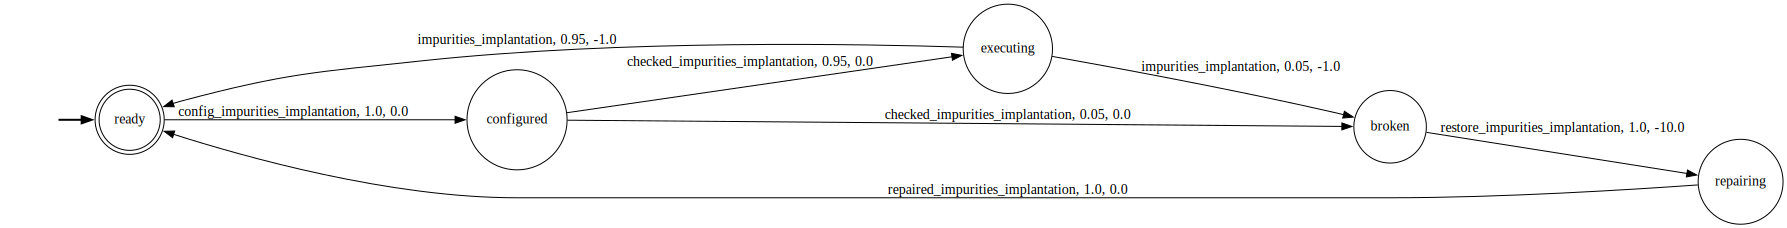

In [22]:
def impurities_implantation_service(name: str, broken_prob: float, unemployable_prob: float, broken_reward: float,
                                    action_reward: float) -> Service:
    """Build the impurities implantation device."""
    return build_complex_breakable_service(name, IMPURITIES_IMPLANTATION, broken_prob=broken_prob,
                                           unemployable_prob=unemployable_prob, broken_reward=broken_reward,
                                           action_reward=action_reward)


service_impurities_implantation = impurities_implantation_service(IMPURITIES_IMPLANTATION_SERVICE_NAME,
                                                                   DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB,
                                                                   DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD)
render_service(service_impurities_implantation)

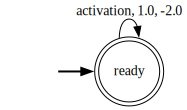

In [23]:
def activation_service(name: str = ACTIVATION_SERVICE_NAME, action_reward: float = USA_REWARD) -> Service:
    """Build the human activation device."""
    return build_generic_service_one_state(
        name,
        {ACTIVATION},
        action_reward=action_reward
    )


service_activation = activation_service()
render_service(service_activation)


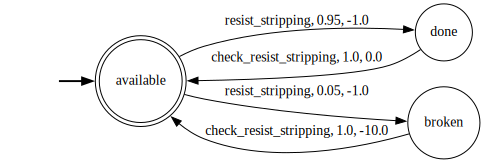

In [24]:
def resist_stripping_service(name: str, broken_prob: float, broken_reward: float, action_reward: float) -> Service:
    """Build the resist stripping device."""
    return build_generic_breakable_service(name, RESIST_STRIPPING, broken_prob=broken_prob, broken_reward=broken_reward,
                                           action_reward=action_reward)


service_resist_stripping = resist_stripping_service(RESIST_STRIPPING_SERVICE_NAME, DEFAULT_BROKEN_PROB,
                                                     DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD)
render_service(service_resist_stripping)

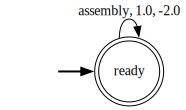

In [25]:
def assembly_service(name: str = ASSEMBLY_SERVICE_NAME, action_reward: float = USA_REWARD) -> Service:
    """Build the human assembly device."""
    return build_generic_service_one_state(
        name,
        {ASSEMBLY},
        action_reward=action_reward
    )


service_assembly = assembly_service()
render_service(service_assembly)

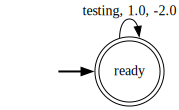

In [26]:
def testing_service(name: str = TESTING_SERVICE_NAME, action_reward: float = USA_REWARD) -> Service:
    """Build the human testing device."""
    return build_generic_service_one_state(
        name,
        {TESTING},
        action_reward=action_reward
    )


service_testing = testing_service()
render_service(service_testing)


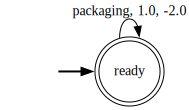

In [27]:
def packaging_service(name: str = PACKAGING_SERVICE_NAME, action_reward: float = USA_REWARD) -> Service:
    """Build the human packaging device."""
    return build_generic_service_one_state(
        name,
        {PACKAGING},
        action_reward=action_reward
    )


service_packaging = packaging_service()
render_service(service_packaging)

# First Phase - Raw materials and design assortment
## Target Specification
The target specification of the first phase is defined as follows:

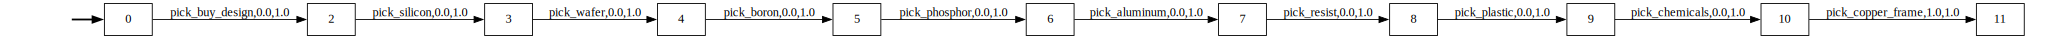

In [30]:
constraints = [
    build_declare_assumption(set(SYMBOLS_PHASE_1)),
    *[exactly_once(x) for x in SYMBOLS_PHASE_1],
]

for i in range(len(SYMBOLS_PHASE_1) - 1):
    for j in range(i, len(SYMBOLS_PHASE_1)):
        constraints.append(alt_precedence(SYMBOLS_PHASE_1[i], SYMBOLS_PHASE_1[j]))
formula = pylogics.parsers.ltl.parse_ltl(" & ".join(constraints))
automaton = logaut.core.ltl2dfa(formula, backend="lydia")
declare_automaton = from_symbolic_automaton_to_declare_automaton(automaton, set(SYMBOLS_PHASE_1))
render_mdp_dfa(mdp_from_dfa(declare_automaton), no_sink=True)


## Composition MDP
The Composition MDP is constructed in this way:

In [32]:
all_services = [
    # 0
    design_service(DESIGN_SERVICE_NAME_USA, USA_REWARD),
    # 1
    design_service(DESIGN_SERVICE_NAME_UK, UK_REWARD),
    # 2
    design_service(DESIGN_SERVICE_NAME_CHINA, CHINA_REWARD),
    # 3
    design_service(DESIGN_SERVICE_NAME_TAIWAN, TAIWAN_REWARD),
    # 4
    silicon_warehouse_service(SILICON_SERVICE_NAME_CHINA, CHINA_REWARD),
    # 5
    silicon_warehouse_service(SILICON_SERVICE_NAME_RUSSIA, RUSSIA_REWARD + WAR_REWARD),
    # 6
    silicon_warehouse_service(SILICON_SERVICE_NAME_NORWAY, NORWAY_REWARD),
    # 7
    silicon_warehouse_service(SILICON_SERVICE_NAME_USA, USA_REWARD),
    # 8
    silicon_warehouse_service(SILICON_SERVICE_NAME_BRAZIL, BRAZIL_REWARD),
    # 9
    silicon_warehouse_service(SILICON_SERVICE_NAME_FRANCE, FRANCE_REWARD),
    # 10
    silicon_warehouse_service(SILICON_SERVICE_NAME_MALAYSIA, MALAYSIA_REWARD),
    # 11
    wafer_warehouse_service(WAFER_SERVICE_NAME_JAPAN, JAPAN_REWARD),
    # 12
    wafer_warehouse_service(WAFER_SERVICE_NAME_SOUTH_KOREA, SOUTH_KOREA),
    # 13
    boron_warehouse_service(BORON_SERVICE_NAME_CHINA, CHINA_REWARD),
    # 14
    boron_warehouse_service(BORON_SERVICE_NAME_USA, USA_REWARD),
    # 15
    boron_warehouse_service(BORON_SERVICE_NAME_CHILE, CHILE_REWARD),
    # 16
    boron_warehouse_service(BORON_SERVICE_NAME_KAZAKHSTAN, KAZAKHSTAN_REWARD),
    # 17
    boron_warehouse_service(BORON_SERVICE_NAME_RUSSIA, RUSSIA_REWARD + WAR_REWARD),
    # 18
    boron_warehouse_service(BORON_SERVICE_NAME_ARGENTINA, ARGENTINA_REWARD),
    # 19
    boron_warehouse_service(BORON_SERVICE_NAME_BOLIVIA, BOLIVIA_REWARD),
    # 20
    boron_warehouse_service(BORON_SERVICE_NAME_TURKEY, TURKEY_REWARD),
    # 21
    phosphor_warehouse_service(PHOSPHOR_SERVICE_NAME_CHINA, CHINA_REWARD),
    # 22
    phosphor_warehouse_service(PHOSPHOR_SERVICE_NAME_MOROCCO, MOROCCO_REWARD),
    # 23
    phosphor_warehouse_service(PHOSPHOR_SERVICE_NAME_USA, USA_REWARD),
    # 24
    aluminum_warehouse_service(ALUMINUM_SERVICE_NAME_AUSTRALIA, AUSTRALIA_REWARD),
    # 25
    aluminum_warehouse_service(ALUMINUM_SERVICE_NAME_BRAZIL, BRAZIL_REWARD),
    # 26
    aluminum_warehouse_service(ALUMINUM_SERVICE_NAME_INDIA, INDIA_REWARD),
    # 27
    resist_warehouse_service(RESIST_SERVICE_NAME_USA, USA_REWARD),
    # 28
    resist_warehouse_service(RESIST_SERVICE_NAME_SWITZERLAND, SWITZERLAND_REWARD),
    # 29
    resist_warehouse_service(RESIST_SERVICE_NAME_INDIA, INDIA_REWARD),
    # 30
    resist_warehouse_service(RESIST_SERVICE_NAME_CANADA, CANADA_REWARD),
    # 31
    resist_warehouse_service(RESIST_SERVICE_NAME_BELGIUM, BELGIUM_REWARD),
    # 32
    resist_warehouse_service(RESIST_SERVICE_NAME_AUSTRIA, AUSTRIA_REWARD),
    # 33
    plastic_warehouse_service(PLASTIC_SERVICE_NAME_CHINA, CHINA_REWARD),
    # 34
    plastic_warehouse_service(PLASTIC_SERVICE_NAME_INDIA, INDIA_REWARD),
    # 35
    chemicals_warehouse_service(CHEMICALS_SERVICE_NAME_CANADA, CANADA_REWARD),
    # 36
    chemicals_warehouse_service(CHEMICALS_SERVICE_NAME_USA, USA_REWARD),
    # 37
    copper_frame_warehouse_service(COPPER_FRAME_SERVICE_NAME_CHILE, CHILE_REWARD),
    # 38
    copper_frame_warehouse_service(COPPER_FRAME_SERVICE_NAME_CHINA, CHINA_REWARD),
    # 39
    copper_frame_warehouse_service(COPPER_FRAME_SERVICE_NAME_PERU, PERU_REWARD),
    # 40
    copper_frame_warehouse_service(COPPER_FRAME_SERVICE_NAME_USA, USA_REWARD)
]
trimmed_declare_automaton = declare_automaton.trim()
stochastic_target = target_from_dfa(trimmed_declare_automaton)
#mdp = comp_mdp(declare_automaton, all_services, gamma=0.9)
mdp = composition_mdp(stochastic_target, *all_services, gamma=0.9)
render_composition_mdp(mdp)

ValueError: 

# Optimal policy
Calculation of optimal policy:

In [ ]:
opn = DPAnalytic(mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
value_function = opn.get_value_func_dict(opt_policy)
q_value_function = opn.get_act_value_func_dict(opt_policy)


In [ ]:
print_policy_data(opt_policy)

# Value Function
Calculation of Value Function:

In [ ]:
print_value_function(value_function)

In [ ]:
print_q_value_function(q_value_function)

# Second phase - Manufacturing Process
## Target Specification
The target specification of the second phase is structured as follows:


In [31]:
constraints = [
    build_declare_assumption(set(SYMBOLS_PHASE_2)),
    *[exactly_once(x) for x in SYMBOLS_PHASE_2],
]

for i in range(len(SYMBOLS_PHASE_2) - 1):
    for j in range(i, len(SYMBOLS_PHASE_2)):
        constraints.append(alt_precedence(SYMBOLS_PHASE_2[i], SYMBOLS_PHASE_2[j]))
formula = pylogics.parsers.ltl.parse_ltl(" & ".join(constraints))
automaton = logaut.core.ltl2dfa(formula, backend="lydia")
declare_automaton = from_symbolic_automaton_to_declare_automaton(automaton, set(SYMBOLS_PHASE_2))
render_mdp_dfa(mdp_from_dfa(declare_automaton), no_sink=True)

Exception: the Lydia command lydia.bat --logic=ltlf --file=temp_file.ltlf -p failed.
stdout=
(MDP-Planner-Chip-Production) C:\Users\silo\MDP-Planner-Chip-Production\docs\notebooks>docker run --rm --name lydia -v"C:\Users\silo\MDP-Planner-Chip-Production\docs\notebooks":/home/default whitemech/lydia lydia --logic=ltlf --file=temp_file.ltlf -p 
[2023-03-16 15:57:27.041] [lydia] [info] [main] Parsing "temp_file.ltlf"
[2023-03-16 15:57:27.773] [lydia] [info] [main] Transforming to DFA...

stderr=

In [ ]:
all_services = [
    # 0
    cleaning_service(CLEANING_SERVICE_NAME, USA_REWARD),
    # 1
    film_deposition_service(FILM_DEPOSITION1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
    # 2
    film_deposition_service(FILM_DEPOSITION2_SERVICE_NAME, BROKEN_PROB, HIGH_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, USA_REWARD),
    # 3
    resist_coating_service(RESIST_COATING1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
    # 4
    resist_coating_service(RESIST_COATING2_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, USA_REWARD),
    # 5
    exposure_service(EXPOSURE_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
    # 6
    development_service(DEVELOPMENT1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
    # 7
    development_service(DEVELOPMENT2_SERVICE_NAME, BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB, DEFAULT_BROKEN_REWARD, HIGH_USA_REWARD),
    # 8
    etching_service(ETCHING1_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
    # 9
    etching_service(ETCHING2_SERVICE_NAME, BROKEN_PROB, DEFAULT_BROKEN_REWARD, HIGH_USA_REWARD),
    # 10
    impurities_implantation_service(IMPURITIES_IMPLANTATION_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_UNEMPLOYABLE_PROB,DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
    # 11
    activation_service(ACTIVATION_SERVICE_NAME, USA_REWARD),
    # 12
    resist_stripping_service(RESIST_STRIPPING_SERVICE_NAME, DEFAULT_BROKEN_PROB, DEFAULT_BROKEN_REWARD, DEFAULT_USA_REWARD),
    # 13
    assembly_service(ASSEMBLY_SERVICE_NAME, USA_REWARD),
    # 14
    testing_service(TESTING_SERVICE_NAME, USA_REWARD),
    # 15
    packaging_service(PACKAGING_SERVICE_NAME, USA_REWARD)
]
trimmed_declare_automaton = declare_automaton.trim()
stochastic_target = target_from_dfa(trimmed_declare_automaton)
#mdp = comp_mdp(declare_automaton, all_services, gamma=0.9)
mdp = composition_mdp(stochastic_target, *all_services, gamma=0.9)
#render_composition_mdp(mdp)
print("Number of states: ", len(mdp.all_states))

# Optimal policy
Calculation of optimal policy:

In [ ]:
opn = DPAnalytic(mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
value_function = opn.get_value_func_dict(opt_policy)
q_value_function = opn.get_act_value_func_dict(opt_policy)

In [ ]:
print_policy_data(opt_policy)

# Value Function
Calculation of Value Function:

In [ ]:
print_value_function(value_function)

In [ ]:
print_q_value_function(q_value_function)